# Mask Flow Net  for Flow Model Training

setup dataloaders, loss, optimizer, execute training loop, output curves to tensorboard, view results via tensorboard <br><br>

Using pretrained MaskFlownet for Optical Flow: <br>
https://github.com/microsoft/MaskFlownet <br><br>


Why are we doing this? <br>
"How far can the 2-frame classical methods be pushed?
Our sense is that they are likely to improve incrementally
for several years to come, but that the big gains will come
from methods that go beyond the classical formulation to
reason more explicitly about surfaces and boundaries and
how they move over time." http://cs.brown.edu/~dqsun/pubs/cvpr_2010_flow.pdf




# REQUIRED INSTALLS:

for CUDA 10.2 (adjust accordingly for other versions):

pip3 install mxnet-cu102

In [28]:
import os
import sys
import shutil
from tqdm import tqdm
from pathlib import Path
import time
import ipywidgets as widgets
from IPython.html.widgets import *
import pickle
import ntpath
import collections
import shutil

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from efficientnet_pytorch import EfficientNet
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms, utils
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%matplotlib inline

In [29]:
DATA_PATH = Path('../data/').resolve()
TRAIN_VIDEO = DATA_PATH/'train.mp4'
TEST_VIDEO = DATA_PATH/'test.mp4'
CLEAN_DATA_PATH = Path('../data/').resolve()

TRAIN_PATH = DATA_PATH/'train'
VAL_PATH = DATA_PATH/'val'
TEST_PATH = DATA_PATH/'test'
HOLDOUT_PATH = DATA_PATH/'holdout'

MODEL_PATH = Path('../models/').resolve()

In [30]:
import sys
sys.path.append('../')

from source.custom_transforms import (open_image_from_path, Crop, GaussianBlur, RandomBrightness, 
                                      opticalFlowDense, RICAP, ToTensor, ToNumpy)


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Training Parameters

In [31]:
seed = 42

# hyperparameters
batch_size = 5
num_epochs = 50 #100 #90

# Detect if we have a GPU available
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    dtype = torch.cuda.FloatTensor
    batch_size *= torch.cuda.device_count()
else:
    dtype = torch.FloatTensor

# Loading Meta dataset

In [32]:
train_meta = pd.read_csv(TRAIN_PATH/'train_meta.csv')
print('shape: ', train_meta.shape)
val_meta = pd.read_csv(VAL_PATH/'val_meta.csv')
print('shape: ', val_meta.shape)
holdout_meta = pd.read_csv(HOLDOUT_PATH/'holdout_meta.csv')
print('shape: ', holdout_meta.shape)

shape:  (14280, 3)
shape:  (4080, 3)
shape:  (2040, 3)


In [33]:
train_ids = train_meta['image_index'].values
val_ids = val_meta['image_index'].values
holdout_ids = holdout_meta['image_index'].values

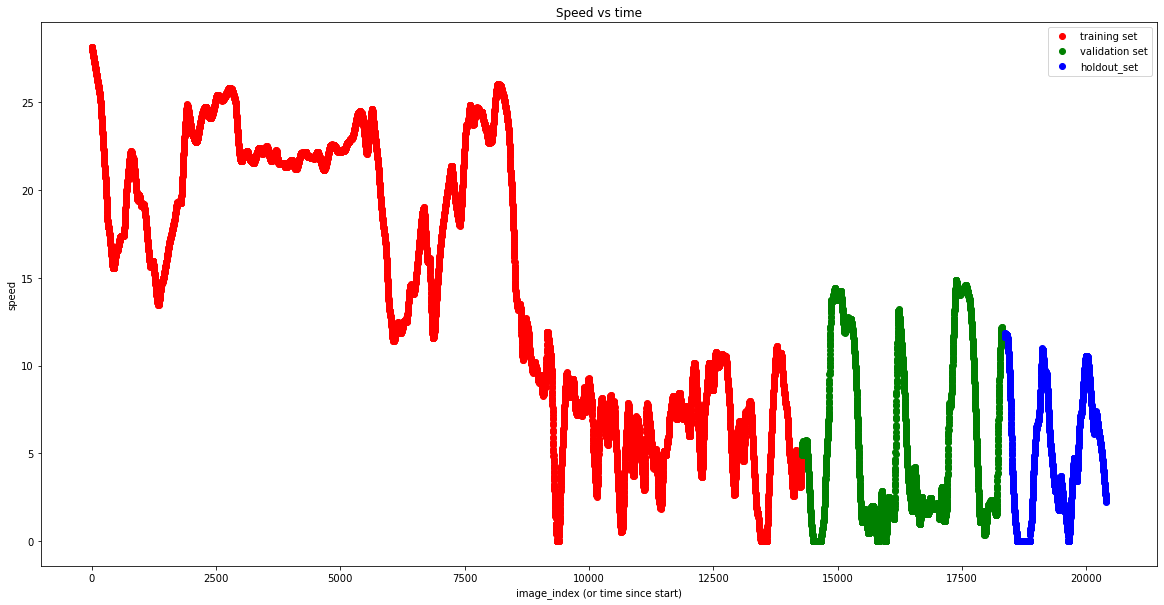

----
train_data:  14280
valid_data:  4080


In [34]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(train_ids, train_meta['speed'], 'ro')
plt.plot(val_ids, val_meta['speed'], 'go')
plt.plot(holdout_ids, holdout_meta['speed'], 'bo')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Speed vs time')
plt.legend(['training set', 'validation set', 'holdout_set'], loc='upper right')
plt.show()
plt.close()

print('----')
print('train_data: ', len(train_ids))
print('valid_data: ', len(val_ids))

# Data setup: transformations, Dataset, Dataloader

In [35]:
RICAP = RICAP(0.4, (0.2, 0.4))
ToTensor = ToTensor(dtype)

In [36]:
#path to MaskFlownet repo
mask_flow_net_path = Path('../../MaskFlownet').resolve()
if not str(mask_flow_net_path) in sys.path:
    sys.path.append(str(mask_flow_net_path))
    
import data_predictor

In [37]:
mask_flow_helper = data_predictor.MaskFlowHelper()

[('/home/jared/Research/MaskFlownet/logs/8caNov12-1532.log', '8caNov12-1532', '-1532')]

Default FLAGS..network.flow_multiplier to 1.0
Default FLAGS..network.deform_bias to True
Default FLAGS..network.upfeat_ch to [16, 16, 16, 16]
Default FLAGS..network.flow_multiplier to 1.0
Default FLAGS..network.deform_bias to True
Default FLAGS..network.upfeat_ch to [16, 16, 16, 16]
Default FLAGS..network.mw to [0.005, 0.01, 0.02, 0.08, 0.32]
Default FLAGS..optimizer.q to None
Load Checkpoint /home/jared/Research/MaskFlownet/weights/8caNov12-1532_300000.params
load the weight for the network
fix the weight for the head network


In [38]:
class OpticalFlowDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, overwrite_flow, pre_flow_transforms=None, post_flow_transforms=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory to create flow_images folder
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.flow_dir = root_dir/"mask_flow_images"
        self.overwrite_flow = overwrite_flow
        self.pre_transform = pre_flow_transforms
        self.post_transforms = post_flow_transforms
        
        self._make_flow(csv_file);
        
    def _make_flow(self, csv_file):
        os.makedirs(self.flow_dir, exist_ok=True)
        if(self.overwrite_flow == False):
            new_df = pd.read_csv(self.root_dir/f'{str(csv_file)[:-4]}_mask_flow.csv')
            
            cur_flow = [f for f in os.listdir(self.flow_dir) if f.endswith('.jpg')]
            flow_paths = new_df['flow_path'].apply(ntpath.basename).values
            
            if collections.Counter(self.df['image_path'].values[:-1]) != collections.Counter(new_df['image_path'].values):
                raise ValueError("Overwrite set to false, but old and new dataframe do not match")
            if collections.Counter(cur_flow) != collections.Counter(flow_paths):
                raise ValueError("Overwrite set to false, but Dataframe and current images saved do not match")
 
            self.df = new_df
            return
        
        #delete all files
        all_paths = [os.path.join(self.flow_dir, f) for f in os.listdir(self.flow_dir) if f.endswith(".jpg") ]
        for f in all_paths:
            os.remove(f)
    
        names = []
        for idx in range(0, self.df.shape[0]-1):
            sample = self._get_frames(idx)

            #get rgb flow
            flow = mask_flow_helper.get_flow(sample['frame1'], sample['frame2'])
            
            #save as rgb
            basename = ntpath.basename(sample['frame1_name'])
            save_path = str(self.flow_dir/basename)
            cv2.imwrite(save_path, flow)
            names += [save_path]
        
        #remove last frame from dataset, flow does not exist here
        self.df.drop(self.df.tail(1).index,inplace=True)
    
        #save paths to df
        self.df['flow_path'] = names
        csv_name = ntpath.basename(csv_file)
        self.df.to_csv(self.root_dir/f'{str(csv_file)[:-4]}_mask_flow.csv', index=False)

    def __len__(self):
        return len(self.df)

    def _get_frames(self, idx):
        """
        returns the frames used to consturct the flow for a given index
        
        (i),(i+1) used to calculate flow for index i
        """
        frame1_name = self.df.iloc[idx]['image_path']
        frame2_name = self.df.iloc[idx+1]['image_path']

        frame1 = open_image_from_path(frame1_name)
        frame2 = open_image_from_path(frame2_name)
                   
        sample = {'frame1_name': frame1_name, 'frame1': frame1, 
                  'frame2_name': frame2_name, 'frame2': frame2}
        
        if self.pre_transform:
            sample = self.pre_transform(sample)
            
        return sample
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        #read in rgb
        sample = {'image': cv2.imread(self.df['flow_path'].values[idx]),
                  'speed': self.df['speed'].values[idx]}

        if self.post_transforms:
            sample['image'] = self.post_transforms(sample['image'])
            sample['speed'] = torch.tensor(sample['speed']).type(dtype)
        
        return sample

#### initializing dataset

In [39]:
#calc normalization values
calc_norm = True

if calc_norm:
    print("Initializing Datasets and Dataloaders...")

    train_flow = OpticalFlowDataset(TRAIN_PATH/'train_meta.csv', 
                                    TRAIN_PATH,
                                    overwrite_flow = True,
                                    pre_flow_transforms = transforms.Compose([Crop()
                                                                              ]),
                                    post_flow_transforms = transforms.Compose([ToTensor
                                                                              ])
                                   )


    train_dataloader = DataLoader(train_flow, batch_size=batch_size, shuffle=True, num_workers=0)
    print('train initialized')

    val_flow = OpticalFlowDataset(VAL_PATH/'val_meta.csv', 
                                  VAL_PATH,
                                  overwrite_flow = True,
                                  pre_flow_transforms = transforms.Compose([Crop()]),
                                  post_flow_transforms = transforms.Compose([ToTensor
                                                                            ])
                                 )

    val_dataloader = DataLoader(val_flow, batch_size=batch_size, shuffle=False, num_workers=0)
    print('val initialized')


    print('computing normalization values from training dataset')
    #computing normalization values:
    pop_mean = []
    pop_std0 = []
    pop_std1 = []
    for i, data in enumerate(train_dataloader, 0):
        # shape (batch_size, 3, height, width)
        if device.type == 'cuda':
            numpy_image = data['image'].cpu().numpy()
        else:
            numpy_image = data['image'].numpy()

        # shape (3,)
        batch_mean = np.mean(numpy_image, axis=(0,2,3))
        batch_std0 = np.std(numpy_image, axis=(0,2,3))
        batch_std1 = np.std(numpy_image, axis=(0,2,3), ddof=1)

        pop_mean.append(batch_mean)
        pop_std0.append(batch_std0)
        pop_std1.append(batch_std1)

    # shape (num_iterations, 3) -> (mean across 0th axis) -> shape (3,)
    normalize_vals = [list(np.array(pop_mean).mean(axis=0)),
                   list(np.array(pop_std0).mean(axis=0))] 
    
    print('mean;std0;std1')
    print(normalize_vals[0], '', sep=', ')
    print(normalize_vals[1], '', sep=', ')
    print(list(np.array(pop_std1).mean(axis=0)), sep=', ')

Initializing Datasets and Dataloaders...
train initialized
val initialized
computing normalization values from training dataset
mean;std0;std1
[240.98872, 232.4237, 228.07513], 
[30.882467, 36.728863, 41.858036], 
[30.882477, 36.72887, 41.85805]


In [40]:
#copy the printed values and save them to skip normalize calculations:
if not calc_norm:
    print('mean;std0;std1')
    all_vals = [[212.00021, 204.8048, 201.72067], 
                [82.84907, 82.2566, 83.179825], 
                [82.84907, 82.25661, 83.17984]]

    normalize_vals = all_vals[0:2]
    for val in all_vals:
        print(val)

In [41]:
print("Initializing Datasets and Dataloaders...")
    
train_flow = OpticalFlowDataset(TRAIN_PATH/'train_meta.csv', 
                                TRAIN_PATH,
                                overwrite_flow = False,
                                pre_flow_transforms = transforms.Compose([Crop(),                                                                         RandomBrightness(), 
                                                                          ]),
                                post_flow_transforms = transforms.Compose([ToTensor,
                                                                           transforms.Normalize(normalize_vals[0], 
                                                                                                normalize_vals[1])
                                                                          ])
                               )
                        

train_dataloader = DataLoader(train_flow, batch_size=batch_size, shuffle=True, num_workers=0)
print('train initialized')

val_flow = OpticalFlowDataset(VAL_PATH/'val_meta.csv', 
                              VAL_PATH,
                              overwrite_flow = False,
                              pre_flow_transforms = transforms.Compose([Crop()]),
                              post_flow_transforms = transforms.Compose([ToTensor,
                                                                         transforms.Normalize(normalize_vals[0], 
                                                                                                normalize_vals[1])
                                                                        ])
                             )

val_dataloader = DataLoader(val_flow, batch_size=batch_size, shuffle=False, num_workers=0)
print('val initialized')



Initializing Datasets and Dataloaders...
train initialized
val initialized


In [42]:
del mask_flow_helper

#### visualizing flow

0 torch.Size([20, 3, 220, 570]) torch.Size([20])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 torch.Size([20, 3, 220, 570]) torch.Size([20])
2 torch.Size([20, 3, 220, 570]) torch.Size([20])
3 torch.Size([20, 3, 220, 570]) torch.Size([20])


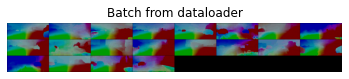

In [43]:
# Helper function to show a batch
def show_flow(images_batched):
    """Show image with landmarks for a batch of samples."""
    im_size = images_batched.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batched)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.title('Batch from dataloader')

for i_batch, data in enumerate(train_dataloader):
    if device.type == 'cuda':
        data['image'] = data['image'].cpu()
        data['speed'] = data['speed'].cpu()
        
    print(i_batch, data['image'].size(),
          data['speed'].size())
    
    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_flow(data['image'])
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

#### Before and after

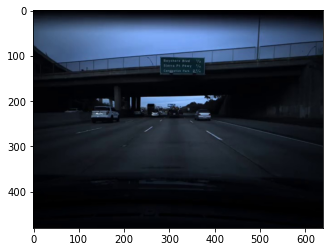

In [44]:
temp = open_image_from_path(train_flow.df.iloc[0]['image_path'])
plt.imshow(temp)

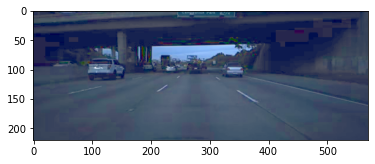

In [45]:
sample = train_flow._get_frames(0)
plt.imshow(sample['frame1'])

#### saved flow

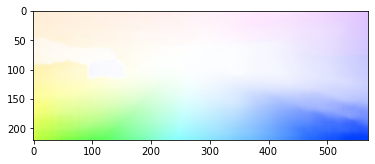

In [46]:
sample = open_image_from_path(train_flow.df.iloc[0]['flow_path'])
plt.imshow(sample)

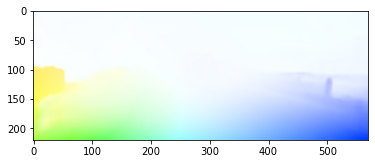

In [54]:
sample = open_image_from_path(val_flow.df.iloc[100]['flow_path'])
plt.imshow(sample)

#### post transformation flow

In [56]:
it = iter(train_flow)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


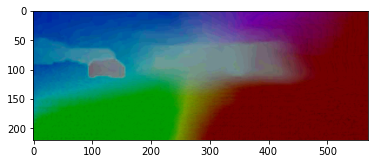

In [57]:
plt.imshow(ToNumpy()(next(it)['image'].cpu()))

# Training Setup: Model, Optimizer, Loss, Epochs, TensorBoard


In [58]:
# run specific constants
model_name = 'efficientnet-b4'
run_name = 'mask_flow_net-{}-batch={}-epochs={}'.format(model_name,batch_size, num_epochs)

model_filepath = os.path.join(MODEL_PATH, run_name)
os.makedirs(model_filepath, exist_ok=True)
tensorboard_loc = os.path.join(model_filepath, 'tensorboard')
writer = SummaryWriter(tensorboard_loc)
shutil.copyfile('mask_flow_net_deep_learning.ipynb', os.path.join(model_filepath, 'nb_backup.ipynb'))

'/home/jared/Research/speed_detection/models/mask_flow_net-efficientnet-b4-batch=20-epochs=50/nb_backup.ipynb'

In [59]:
#model = EfficientNet.from_pretrained(f'{model_name}')
model = EfficientNet.from_name(f'{model_name}')
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 1)

start_epoch = 0
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
#optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

if device.type == 'cuda':
    if torch.cuda.device_count() > 1:
        gpu_ids = list(range(torch.cuda.device_count()))
        model = nn.DataParallel(model, device_ids=gpu_ids)

for param in model.parameters():
    param.requires_grad = True
        
model.to(device)

DataParallel(
  (module): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        

In [60]:
load_checkpoint = False

if load_checkpoint == True:
    print('loading checkpoint')
    #change to your model checkpoint loc
    checkpoint_path = Path("../models/efficientnet-b4-batch=20-epochs=50/model_30.pt").resolve()
    checkpoint = torch.load(checkpoint_path)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    train_loss = checkpoint['train_loss']
    val_loss = checkpoint['val_loss']

# PyTorch Training Loop

In [61]:
train_log_iters = len(train_dataloader) // 40
val_log_iters = len(train_dataloader) // 3

print(f'Number of epochs: {num_epochs}')
print(f'Batches per epoch: {len(train_dataloader)}')
print(f'train logging frequency: {train_log_iters}')
print(f'validation logging frequency: {val_log_iters}')

Number of epochs: 50
Batches per epoch: 714
train logging frequency: 17
validation logging frequency: 238


In [62]:
train = True

if train == True:
    print(f'Batches per epoch: {len(train_dataloader)}')
    epoch_loss = None
    
    
    for epoch in range(start_epoch, num_epochs):  # loop over the dataset multiple times
        """
        Start new epoch
        """
        print(f'-----------------starting epoch {epoch}-----------------')
        full_running_loss = 0.0
        running_loss = 0.0
        model.train()

        for i, data in enumerate(train_dataloader, 0):
            """
            Batch operations
            """
            torch.cuda.synchronize()
            since = int(round(time.time()*1000))

            # get the inputs; data is a dict
            inputs = data['image']
            labels = data['speed']

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            outputs = outputs.reshape(outputs.size()[0])
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            full_running_loss += loss.item()

            time_elapsed = int(round(time.time()*1000)) - since
            writer.add_scalar('WallTime/Train Batch (ms)', time_elapsed, epoch * len(train_dataloader) + i) 

            #print(running_loss)

            """
            Train metrics logging
            """
            if i % train_log_iters == train_log_iters - 1:    # every train_log_iters mini-batches... 
                # log the running loss
                writer.add_scalar(f'Loss/Train MSE, {train_log_iters} batches',
                                running_loss / train_log_iters,
                                epoch * len(train_dataloader) + i)    

                # ...log a Matplotlib Figure showing the model's predictions on a
                # random mini-batch
                '''writer.add_figure('predictions vs. actuals',
                                plot_classes_preds(net, inputs, labels),
                                global_step=epoch * len(trainloader) + i)'''


                print(f'batch {i}, train loss: {running_loss}, wall time: {time_elapsed} ms')
                running_loss = 0.0

            """
            Val metrics logging
            """
            if i % val_log_iters == val_log_iters - 1:    # every val_log_iters mini-batches...
                torch.cuda.synchronize()
                since = int(round(time.time()))

                #get validation loss:
                model.eval()
                val_loss = 0.0
                for j, data in enumerate(val_dataloader, 0):
                    with torch.no_grad():
                        inputs = data['image']
                        labels = data['speed']

                        # forward + backward + optimize
                        outputs = model(inputs)
                        outputs = outputs.reshape(outputs.size()[0])
                        loss = criterion(outputs, labels)

                        val_loss += loss.item()

                val_loss = val_loss / len(val_dataloader)
                # log the validation loss
                writer.add_scalar('Loss/Validation MSE',
                                  val_loss,
                                  epoch * len(train_dataloader) + i)

                time_elapsed = int(round(time.time())) - since
                writer.add_scalar('WallTime/Validation Set (s)', time_elapsed, epoch * len(train_dataloader) + i) 

                model.train()
                print(f'** validation MSE: {val_loss}, wall time: {time_elapsed} s**')

        """
        End of Epoch
        """
        if epoch_loss == None or full_running_loss < epoch_loss:
            epoch_loss  = full_running_loss
            checkpoint_path = os.path.join(model_filepath, f'model_{epoch}.pt')
            print(f'saving checkpoint as: {checkpoint_path}')
            torch.save({'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'train_loss': full_running_loss,
                        'val_loss': val_loss,
                        }, checkpoint_path)

        full_running_loss = full_running_loss / len(train_dataloader)
        writer.add_scalar(f'Epoch Loss/Train MSE', full_running_loss, epoch)    
        writer.add_scalar(f'Epoch Loss/Val MSE', val_loss, epoch)    
        
        full_running_loss = 0
    print('Finished Training')
    writer.close()

Batches per epoch: 714
-----------------starting epoch 0-----------------
batch 16, train loss: 3516.9759063720703, wall time: 213 ms
batch 33, train loss: 1620.483512878418, wall time: 234 ms
batch 50, train loss: 953.6065673828125, wall time: 227 ms
batch 67, train loss: 879.6592140197754, wall time: 224 ms
batch 84, train loss: 833.2575016021729, wall time: 228 ms
batch 101, train loss: 776.130184173584, wall time: 225 ms
batch 118, train loss: 814.8809585571289, wall time: 230 ms
batch 135, train loss: 800.8343048095703, wall time: 233 ms
batch 152, train loss: 800.2492828369141, wall time: 336 ms
batch 169, train loss: 808.2554111480713, wall time: 350 ms
batch 186, train loss: 725.4966888427734, wall time: 346 ms
batch 203, train loss: 695.5743770599365, wall time: 224 ms
batch 220, train loss: 695.6915149688721, wall time: 230 ms
batch 237, train loss: 700.3720722198486, wall time: 237 ms
** validation MSE: 130.56453588195876, wall time: 32 s**
batch 254, train loss: 701.5668792

batch 662, train loss: 260.39356803894043, wall time: 340 ms
batch 679, train loss: 224.1851363182068, wall time: 347 ms
batch 696, train loss: 181.53788566589355, wall time: 235 ms
batch 713, train loss: 163.21832704544067, wall time: 223 ms
** validation MSE: 118.35169649591633, wall time: 32 s**
saving checkpoint as: /home/jared/Research/speed_detection/models/mask_flow_net-efficientnet-b4-batch=20-epochs=50/model_2.pt
-----------------starting epoch 3-----------------
batch 16, train loss: 199.09489488601685, wall time: 235 ms
batch 33, train loss: 194.5445818901062, wall time: 227 ms
batch 50, train loss: 199.36104917526245, wall time: 230 ms
batch 67, train loss: 152.9287314414978, wall time: 234 ms
batch 84, train loss: 187.81247663497925, wall time: 228 ms
batch 101, train loss: 198.0842523574829, wall time: 227 ms
batch 118, train loss: 175.71914768218994, wall time: 228 ms
batch 135, train loss: 203.62572717666626, wall time: 240 ms
batch 152, train loss: 194.84361743927002, 

batch 543, train loss: 93.98644733428955, wall time: 231 ms
batch 560, train loss: 128.56945204734802, wall time: 230 ms
batch 577, train loss: 104.93647170066833, wall time: 224 ms
batch 594, train loss: 107.56441473960876, wall time: 237 ms
batch 611, train loss: 100.6011176109314, wall time: 234 ms
batch 628, train loss: 99.62368130683899, wall time: 236 ms
batch 645, train loss: 104.05254983901978, wall time: 224 ms
batch 662, train loss: 101.20429706573486, wall time: 235 ms
batch 679, train loss: 118.59644961357117, wall time: 246 ms
batch 696, train loss: 107.38289499282837, wall time: 235 ms
batch 713, train loss: 94.5414651632309, wall time: 333 ms
** validation MSE: 134.1272798239016, wall time: 32 s**
saving checkpoint as: /home/jared/Research/speed_detection/models/mask_flow_net-efficientnet-b4-batch=20-epochs=50/model_5.pt
-----------------starting epoch 6-----------------
batch 16, train loss: 85.28510570526123, wall time: 335 ms
batch 33, train loss: 80.91598534584045, w

batch 458, train loss: 60.92309629917145, wall time: 227 ms
batch 475, train loss: 42.12315362691879, wall time: 232 ms
** validation MSE: 135.7773781523985, wall time: 32 s**
batch 492, train loss: 44.47749400138855, wall time: 239 ms
batch 509, train loss: 74.75646138191223, wall time: 230 ms
batch 526, train loss: 62.4636595249176, wall time: 229 ms
batch 543, train loss: 55.52521228790283, wall time: 325 ms
batch 560, train loss: 59.87245047092438, wall time: 336 ms
batch 577, train loss: 50.31703305244446, wall time: 335 ms
batch 594, train loss: 58.46413588523865, wall time: 236 ms
batch 611, train loss: 54.15055477619171, wall time: 228 ms
batch 628, train loss: 65.88422203063965, wall time: 224 ms
batch 645, train loss: 49.7991646528244, wall time: 229 ms
batch 662, train loss: 61.241811752319336, wall time: 225 ms
batch 679, train loss: 72.68177556991577, wall time: 230 ms
batch 696, train loss: 58.05493438243866, wall time: 238 ms
batch 713, train loss: 77.8434511423111, wall

batch 390, train loss: 37.08642029762268, wall time: 331 ms
batch 407, train loss: 35.71248644590378, wall time: 231 ms
batch 424, train loss: 38.3002073764801, wall time: 235 ms
batch 441, train loss: 41.29633295536041, wall time: 230 ms
batch 458, train loss: 54.5744606256485, wall time: 225 ms
batch 475, train loss: 50.08304464817047, wall time: 237 ms
** validation MSE: 105.17055920759837, wall time: 31 s**
batch 492, train loss: 71.12857270240784, wall time: 235 ms
batch 509, train loss: 48.633757054805756, wall time: 225 ms
batch 526, train loss: 43.25566565990448, wall time: 231 ms
batch 543, train loss: 50.659645199775696, wall time: 335 ms
batch 560, train loss: 55.59328472614288, wall time: 333 ms
batch 577, train loss: 77.4557638168335, wall time: 329 ms
batch 594, train loss: 52.24454927444458, wall time: 239 ms
batch 611, train loss: 54.21512413024902, wall time: 236 ms
batch 628, train loss: 50.507750391960144, wall time: 225 ms
batch 645, train loss: 50.48074269294739, w

batch 305, train loss: 39.19216012954712, wall time: 243 ms
batch 322, train loss: 37.60547596216202, wall time: 228 ms
batch 339, train loss: 25.514168322086334, wall time: 236 ms
batch 356, train loss: 31.09051787853241, wall time: 329 ms
batch 373, train loss: 27.890739142894745, wall time: 334 ms
batch 390, train loss: 27.81991356611252, wall time: 352 ms
batch 407, train loss: 28.41939812898636, wall time: 231 ms
batch 424, train loss: 37.33597195148468, wall time: 231 ms
batch 441, train loss: 39.12353736162186, wall time: 238 ms
batch 458, train loss: 36.75945997238159, wall time: 234 ms
batch 475, train loss: 30.98757541179657, wall time: 226 ms
** validation MSE: 107.60971108137393, wall time: 32 s**
batch 492, train loss: 35.21436071395874, wall time: 229 ms
batch 509, train loss: 38.038373827934265, wall time: 229 ms
batch 526, train loss: 30.358013451099396, wall time: 229 ms
batch 543, train loss: 29.06921797990799, wall time: 327 ms
batch 560, train loss: 23.6968269348144

KeyboardInterrupt: 

# Evaluation

In [179]:
model.eval()
preds = []
for j, data in enumerate(val_dataloader, 0):
    with torch.no_grad():
        inputs = data['image']
        labels = data['speed']

        # forward + backward + optimize
        outputs = model(inputs)
        outputs = outputs.reshape(outputs.size()[0])
        preds += list(outputs.cpu().numpy())
        
preds.insert(0, preds[1])

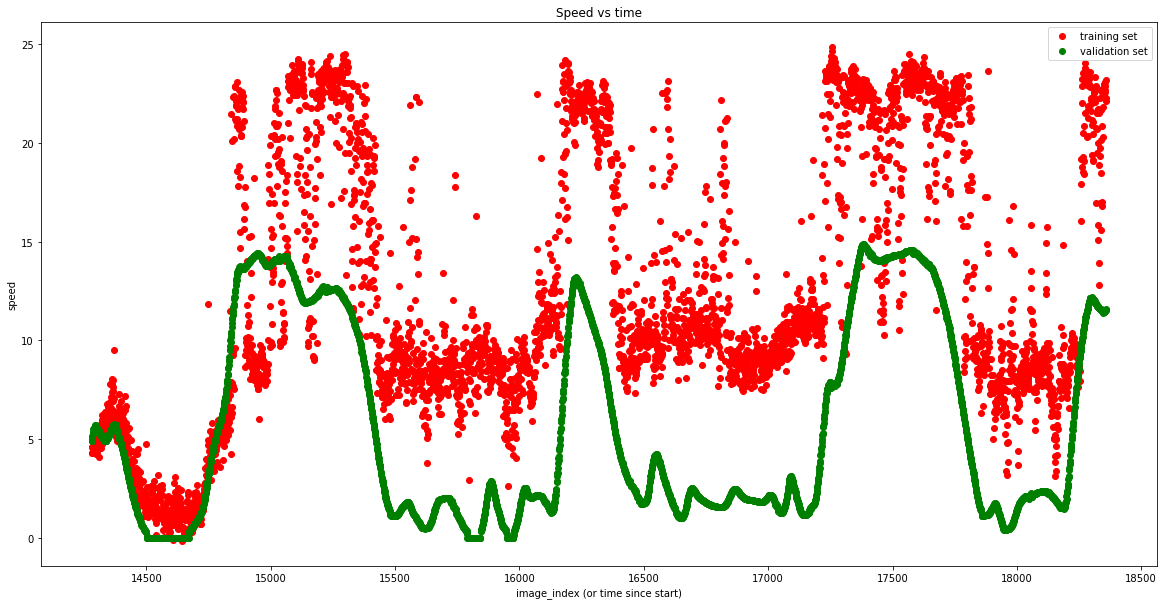

----


66.56439668299458

In [180]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(val_ids, preds, 'ro')
plt.plot(val_ids, val_meta['speed'], 'go')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Speed vs time')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
plt.close()

print('----')
mean_squared_error(val_meta['speed'], preds)

In [181]:
fixed_preds = preds.copy()
bad_preds = [k for k,v in collections.Counter(preds).items() if v > 2]

if fixed_preds[0] in bad_preds:
    for val in fixed_preds[1:]:
        if val not in bad_preds:
            fixed_preds[0] = val
            break
    
for i in range(1, len(fixed_preds)):
    if fixed_preds[i] in bad_preds:
        fixed_preds[i] = fixed_preds[i-1]
    elif fixed_preds[i] < 0:
        fixed_preds[i] = 0
        
        
window = 20
new_preds = fixed_preds[0:window-1]

for i in range(window-1, len(fixed_preds)):
    new_preds += [np.mean(fixed_preds[i-(window-1): i+1])]

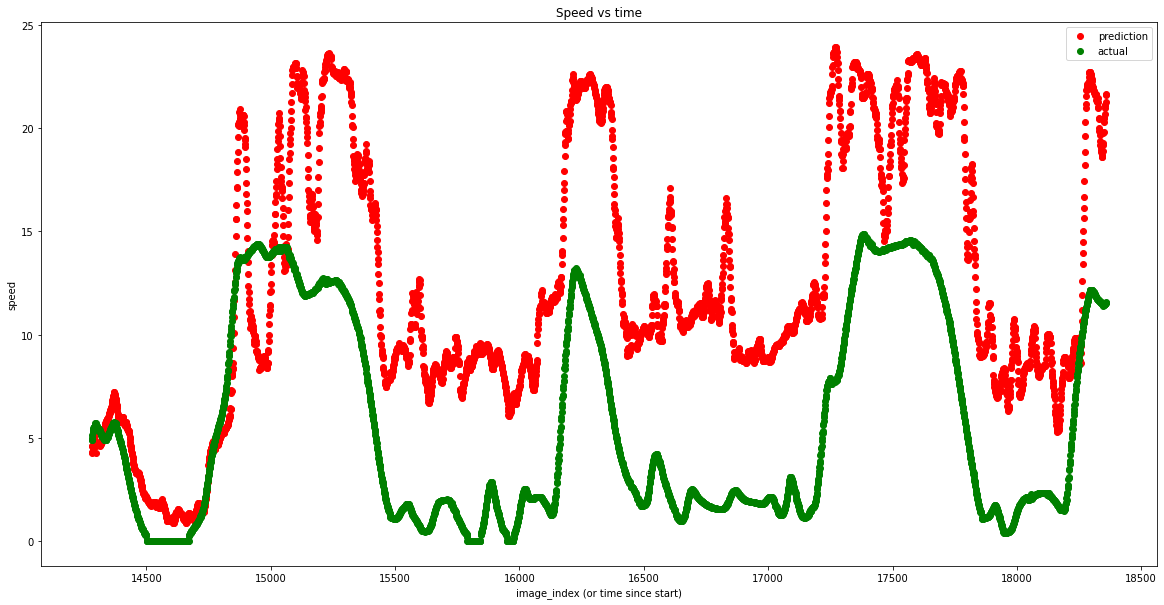

----


61.983686491626905

In [182]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(val_ids, new_preds, 'ro', label='prediction')
plt.plot(val_ids, val_meta['speed'], 'go', label='actual')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Speed vs time')
plt.legend(loc='upper right')
plt.show()
plt.close()

print('----')
mean_squared_error(val_meta['speed'], new_preds)

### Holdout Evaluation

In [183]:
holdout_flow = OpticalFlowDataset(HOLDOUT_PATH/'holdout_meta.csv', 
                                  HOLDOUT_PATH,
                                  overwrite_flow = True,
                                  pre_flow_transforms = transforms.Compose([Crop()]),
                                  post_flow_transforms = transforms.Compose([ToTensor(),
                                                                             transforms.Normalize([7.293118, 5.016652, 4.4507527],
                                                                                                  [22.72919, 18.67817, 14.383012])
                                                                            ])
                             )

holdout_dataloader = DataLoader(holdout_flow, batch_size=batch_size, shuffle=False, num_workers=0)

In [184]:
model.eval()
preds = []
for j, data in enumerate(holdout_dataloader, 0):
    with torch.no_grad():
        inputs = data['image']
        labels = data['speed']

        # forward + backward + optimize
        outputs = model(inputs)
        outputs = outputs.reshape(outputs.size()[0])
        preds += list(outputs.cpu().numpy())
        
preds.insert(0, preds[1])

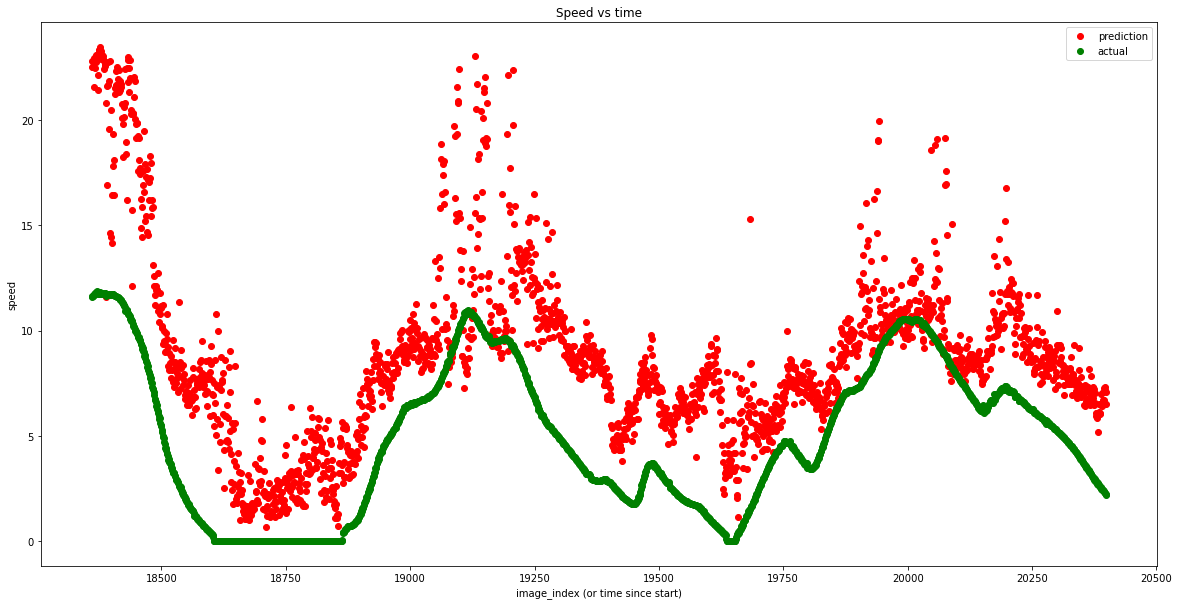

----
mse: 22.244957622567334


In [185]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(holdout_ids, preds, 'ro', label='prediction')
plt.plot(holdout_ids, holdout_meta['speed'], 'go', label='actual')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Speed vs time')
plt.legend(loc='upper right')
plt.show()
plt.close()

print('----')
print(f'mse: {mean_squared_error(holdout_meta["speed"], preds)}')

In [186]:
fixed_preds = preds.copy()
bad_preds = [k for k,v in collections.Counter(preds).items() if v > 2]

if fixed_preds[0] in bad_preds:
    for val in fixed_preds[1:]:
        if val not in bad_preds:
            fixed_preds[0] = val
            break
    
for i in range(1, len(fixed_preds)):
    if fixed_preds[i] in bad_preds:
        fixed_preds[i] = fixed_preds[i-1]
    elif fixed_preds[i] < 0:
        fixed_preds[i] = 0
        
        
window = 30
new_preds = fixed_preds[0:window-1]

for i in range(window-1, len(fixed_preds)):
    new_preds += [np.mean(fixed_preds[i-(window-1): i+1])]

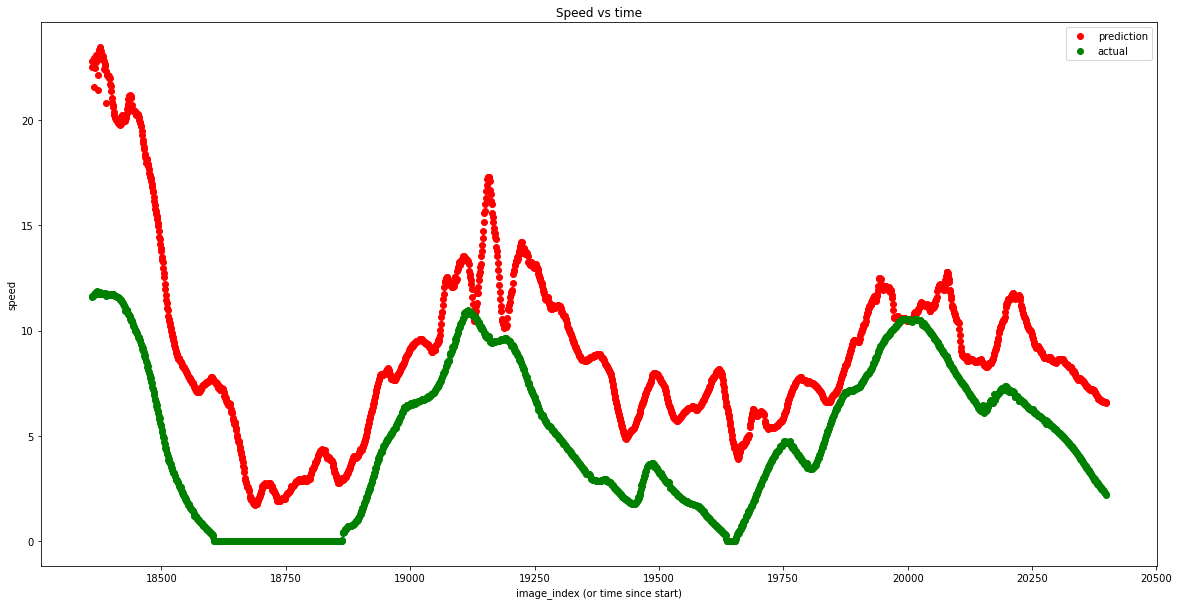

----
mse: 21.711298375722638


In [187]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(holdout_ids, new_preds, 'ro', label='prediction')
plt.plot(holdout_ids, holdout_meta['speed'], 'go', label='actual')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Speed vs time')
plt.legend(loc='upper right')
plt.show()
plt.close()

print('----')
print(f'mse: {mean_squared_error(holdout_meta["speed"], new_preds)}')